In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import yaml
import glob
import plot_helper
from datasets import get_dataset, get_2d_samples
import utils
from nets import load_model
from losses import compute_acc

In [15]:
def glob_grid_experiments(directory):
    data = dict()
    for f in glob.glob(f"{directory}/*/*/summary.yml"):
        with open(f, "r") as fh:
            summary = yaml.safe_load(fh)
            key = "%s--%s--%s" % (summary["model"], summary["strategy"], str(summary["M"]))
            summary['path'] = "/".join(f.split("/")[:-1])
            summary['latent'] = np.load(summary['path'] + "/latent-representation.npy")
            data[key] = summary



            
    return data
    
data = glob_grid_experiments("../artifacts-server/mpg-server/experiment-cifar-2d-test-robustness")

In [17]:
data[list(data.keys())[0]]

{'M': 12,
 'beta': 0.001,
 'dataset': 'cifar10',
 'epoch': 50,
 'lr': 0.001,
 'metrics': {'test': {'I_XZ': 44.027957916259766,
   'I_YZ': 0.6717899441719055,
   'accuracy_L1': 0.6506999731063843,
   'accuracy_L12': 0.6526000499725342,
   'loss': 2.694166660308838},
  'train': {'I_XZ': 55.58919906616211,
   'I_YZ': 3.0458178520202637,
   'accuracy_L1': 0.9900797009468079,
   'accuracy_L12': 0.9914594292640686,
   'loss': 0.3316989541053772}},
 'model': 'resnet20_fcov/z:2',
 'strategy': 'oneshot',
 'path': '../artifacts-server/mpg-server/experiment-cifar-2d-test-robustness/cifar10-various-opts-M12/resnet20_fcov-cifar10--2019-12-20--01-11-41-228570',
 'latent': array([[ 4.00000000e+00, -9.37222481e+00,  5.62565613e+00, ...,
         -4.35512289e-02, -4.35512289e-02,  4.48158905e-02],
        [ 6.00000000e+00, -1.22715855e+01,  2.20698214e+00, ...,
         -2.66629700e-02, -2.66629700e-02,  1.63464006e-02],
        [ 7.00000000e+00, -8.60552609e-01,  4.32598686e+00, ...,
         -3.78102

In [18]:
def alias(n):
    if n[:3] == "seq":
        return n.replace("seq", "algo1")
    elif n[:3] == "alt":
        k = n.split("/")[1].split("|")[0].split(":")[1]
        return f"algo2/k:{k}" 
    else:
        return n

In [19]:
alias("seq/d:20|e:1"), alias("alt/e:5|d:1")

('algo1/d:20|e:1', 'algo2/k:5')

In [30]:
arch = "resnet20_fcov/z:2"

strategies = [
    "oneshot",
#     "seq/d:5|e:1",
    "seq/d:10|e:1",
#     "seq/d:20|e:1", 
#     "alt/e:5|d:1", 
    "alt/e:10|d:1", 
#     "alt/e:20|d:1"
]

M = [1, 6, 12]

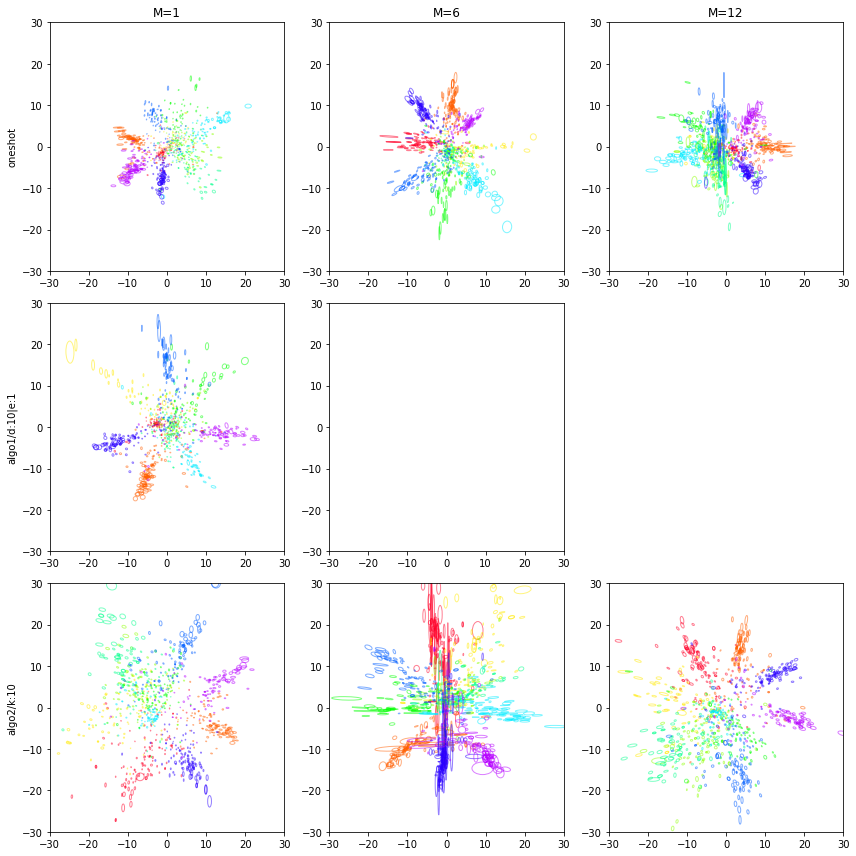

In [32]:
def plot(ax, mu, cov, labels, cm=plt.get_cmap('gist_rainbow')):
    for i in range(10):
        ix = np.argwhere(labels == i)
        ix = ix.reshape(-1)
        plt.scatter(mu[ix, 0], mu[ix, 1], color=cm(i/10), alpha=0.0, label=i)

        for j in range(ix.shape[0]):
            ij = ix[j]
            plot_helper.plot_ellipse(ax, mu[ij,:], cov[ij, :, :], edgecolor=cm(i/10))

    plt.ylim([-30, 30])
    plt.xlim([-30, 30])

def plot_grid(data, arch, strategies, M, p=0.1, L=12):
    total_strategies = len(strategies)
    total_M = len(M)
    
    dataset = data[list(data.keys())[0]]['dataset']
    

    plt.figure(figsize=(4*total_M, 4*total_strategies))
    for i, s in enumerate(strategies):
        for j, m in enumerate(M):
            
            key = f"{arch}--{s}--{m}"
            if key not in data:
                continue 


            ax = plt.subplot(total_strategies, total_M, i*total_M + j+1)
            if i == 0:
                plt.title(f"M={m}")
            if j == 0:
                plt.ylabel(alias(s))
                
                
            path = data[key]['path']
            
            latent = data[key]['latent']
            
            subset_labels = latent[:, 0]
            mu = latent[:, 1:3]
            cov = latent[:, 3:].reshape((-1, 2, 2))

            
            plot(ax, mu, cov, subset_labels)
            

    plt.tight_layout()

    plt.savefig("./figures/resnet2d-cifar10-latent-salt-pepper-p%d.png" % (p*10))
    
plot_grid(data, arch, strategies, M, p=0.0)